In [1]:
import os
import copy
import pylab
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import mne 

from multiprocessing import Pool
import threading

mne.set_log_level('ERROR')

In [2]:
import matplotlib.font_manager
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams["figure.dpi"] = 100
plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually
#%matplotlib tk
import inspect
inspect.getfullargspec(mne.io.read_raw_edf)

FullArgSpec(args=['input_fname', 'eog', 'misc', 'stim_channel', 'exclude', 'infer_types', 'include', 'preload', 'units', 'encoding'], varargs=None, varkw=None, defaults=(None, None, 'auto', (), False, None, False, None, 'utf8'), kwonlyargs=['verbose'], kwonlydefaults={'verbose': None}, annotations={})

Get the path for all files function.

In [3]:
def readPath(path):
    file_path = []
    for root, dirs, files in os.walk(path):
        
        for file in files:
            if file.endswith('.edf'):
                path_name = os.path.join(root, file)
                file_path.append(path_name)
            #print(path_name)

    return file_path


Load the EEG data function.

In [5]:
def loadFile(path, exclude_channels=True, 
                             crop_wake_mins=30):
    """Load a recording from the Sleep Physionet dataset.

    Parameters
    ----------
    raw_fname : str
        Path to the .edf file containing the raw data.
    annot_fname : str
        Path to the annotation file.
    load_eeg_only : bool
        If True, only keep EEG channels and discard other modalities 
        (speeds up loading).
    crop_wake_mins : float
        Number of minutes of wake events before and after sleep events.

    Returns
    -------
    mne.io.Raw :
        Raw object containing the EEG and annotations.        
    """

    mapping = {
    # 'EEG Fp1-AV',
    # #'EEG Fp2-AV',
    # 'EEG C3-AV',
    # #'EEG C4-AV',
    # #'EEG P3-AV',

    # #'EEG O1-AV',
    # #'EEG T3-AV',
    # 'EEG T4-AV',
    # 'EEG Cz-AV',
    # #'EEG Pz-AV',
    # 'EEG O2-AV',
    # 'EEG P4-AV',
    #  'ECG',
    #  'EMG Left_Leg',
    #  'EMG Right_Leg'}

    }
    exclude = mapping if exclude_channels else ()

    #Read the raw data and annotations
    raw = mne.io.read_raw_edf(path, exclude=exclude)
    annots = mne.events_from_annotations(raw)[0]

    if not exclude_channels:
        raw.set_channel_types(mapping)

    # Rename EEG channel
    ch_names = {i: i.replace('EEG ', '') 
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)

    #Save subject and recording information in raw.info
    basename = os.path.basename(path)
    # subj_nb = int(os.path.splitext(basename)[0])
    #raw.info['subject_info'] = {'id': subj_nb}

    return raw

### 读不出的数据汇总：

#### 正常睡眠，补充：
- 收到26个，可读出23个，3个读不来的原因是4th character of start date is not a valid 7-bit ASCII character.
- analysis: improve the sleep model
读不出来的数据如下：
1. Desktop/pylab/EEG数据集/正常睡眠，补充/35W-other/袁艳华之子_A区33N@20231026_231617
2. Desktop/pylab/EEG数据集/正常睡眠，补充/36W-other/张泽正_C区  46床@20231012_111224
3. Desktop/pylab/EEG数据集/正常睡眠，补充/40W-other/肖晓翠之女_D区45床@20230725_142208
   
#### 高胆换血病例EEG-：
- 收到37个，可读出来的共36个。1个读不出来的原因是start date invalid.
- no events & annotations
- analysis: use the sleep model to predict on all data

读不出来的数据如下：
1. Desktop/pylab/EEG数据集/高胆换血病例EEG-/吴桂敏之子（李瀚喆）_567724@20211217_

   
#### 高胆红素血症（换血及未换血各3个）：
- 收到6个，可读出6个。
- analysis: 换血 vs 未换血
- - sleep model
  - wave analysis 


#### After have all the readable data, let's load the path and edf files.

In [10]:
import os
path_0 = './'
path_1 = './healthy-2023'
path_2 = './healthy-2024'
path_3 = './hyper-bloodchange-2024'
path_4 = './hyper-blood-change-notchange-sample'

In [11]:
# res_0 = readPath(path_0) #all data
res_1 = readPath(path_1) #healthy - from 2023
res_2 = readPath(path_2) # healthy - 2024
res_3 = readPath(path_3) #高胆换血病例EEG-
res_4 = readPath(path_4) #高胆红素血症（换血及未换血各3个）

In [12]:
# raws_0 = [loadFile(f) for f in res_0]
raws_1 = [loadFile(f) for f in res_1]
raws_2 = [loadFile(f) for f in res_2]
raws_3 = [loadFile(f) for f in res_3]
raws_4 = [loadFile(f) for f in res_4]

## Exploratory data analysis

There are 3 new datasets. <br>
This notebook is mainly for the general analysis of those new datasets.

General steps:
- events, annotation check, plot_events
- Time domain analysis
- Time-frequency analysis
- is there any metrics that can well represent different datasets?
- todo: explore methods for data analysis


### Dataset specific analysis:

### 1. Healthy new dataset:
- new dataset quality
- will the classification quality increase with the new dataset input?

### 2. 高胆红素-换血:

### 3. 换血未换血:

1. Events table

In [14]:
#Plot event for each raw.edf.
def plotEvents(raw, event_id, chunk_duration=30):
    # event_id = {
    # '清醒1': 3,
    # 'AS1': 2,
    # 'QS1': 1
    # }

    events, _ = mne.events_from_annotations(
    raw, event_id=event_id, 
    chunk_duration=30)

    
    fig = mne.viz.plot_events(
    events,
    event_id=event_id,
    sfreq=raw.info["sfreq"],
    first_samp=events[0, 0],
    )

    # keep the color-code for further plotting
    stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    

Test unit

In [13]:
raw = raws_1[0]
events, annots = mne.events_from_annotations(
    raw, 
    chunk_duration=30) #every event is 30s, (the point is 30s * 500Hz)

In [34]:
def eventTable(raws):
    #Table for events count
    #input: raws: input datasets, only applied to raw 1,2,4. the event_id of raw 3 is different.
    #output: output a dataframe

    res_清醒1 = []
    res_AS1 = []
    res_QS1 = []
   # res_rest = []
    res_all = []

    #Loop through each raw.edf in a dataset-raws
    for raw in raws:  
        events, annots = mne.events_from_annotations(
        raw, 
        chunk_duration=30) #every event is 30s, (the point is 30s * 500Hz)
    
        count_清醒1 = 0
        count_AS1 = 0
        count_QS1 = 0
       # count_rest = 0
    
    
      #count the number of each event: awake, as, qs
        for event in events:
            if event[2] == annots['清醒1']:
                count_清醒1 += 1
            elif event[2] == annots['AS1']:
                count_AS1 += 1
            elif event[2] == annots['QS1']:
                count_QS1 += 1
            # else:
            #     count_rest +=1
        count_all = len(events) #the number of all events for a raw.edf
    
    
    
        res_清醒1.append(count_清醒1)
        res_AS1.append(count_AS1)
        res_QS1.append(count_QS1)
        #res_rest.append(count_rest)
        res_all.append(count_all)
    
    df = pd.DataFrame(list(zip(res_清醒1, res_AS1, res_QS1, res_all)), columns=['Awake', 'AS', 'QS','Sum'])
    df['Awake_percentage'] = round(df['Awake']/df['Sum']*100, 2)
    df['AS_percentage'] = round(df['AS']/df['Sum']*100, 2)
    df['QS_percentage'] = round(df['QS']/df['Sum']*100, 2)


    
    return df
        

Event number and percentage for dataset 1, 2, 4:

In [35]:
print('Number and precentage of events (Awake, AS, QS): \nDataset 1: Healthy neonates EEG received on 2023-10-09:')
df_1 = eventTable(raws_1)
df_1

Number and precentage of events (Awake, AS, QS): 
Dataset 1: Healthy neonates EEG received on 2023-10-09:


,Awake,AS,QS,Sum,Awake_percentage,AS_percentage,QS_percentage
0,226,277,281,784,28.83,35.33,35.84
1,252,106,121,479,52.61,22.13,25.26
2,90,267,115,472,19.07,56.57,24.36
3,92,165,106,363,25.34,45.45,29.20
4,136,244,89,469,29.00,52.03,18.98
5,263,201,83,547,48.08,36.75,15.17
6,86,240,146,472,18.22,50.85,30.93
7,139,196,151,486,28.60,40.33,31.07
8,148,213,113,474,31.22,44.94,23.84
9,54,267,178,499,10.82,53.51,35.67


In [37]:
print('Number and precentage of events (Awake, AS, QS): \nDataset 2: Healthy neonates EEG received on 2024-03-05:')
df_2 = eventTable(raws_2)
df_2

Number and precentage of events (Awake, AS, QS): 
Dataset 2: Healthy neonates EEG received on 2024-03-05:


,Awake,AS,QS,Sum,Awake_percentage,AS_percentage,QS_percentage
0,43,183,189,415,10.36,44.10,45.54
1,101,178,129,408,24.75,43.63,31.62
2,101,189,91,381,26.51,49.61,23.88
3,52,162,64,278,18.71,58.27,23.02
4,28,84,23,135,20.74,62.22,17.04
5,141,289,124,554,25.45,52.17,22.38
6,177,210,129,516,34.30,40.70,25.00
7,101,271,118,490,20.61,55.31,24.08
8,57,234,117,408,13.97,57.35,28.68
9,85,240,170,495,17.17,48.48,34.34


In [36]:
print('Number and precentage of events (Awake, AS, QS): \nDataset 4: hyperbilirubin neonates EEG (exchange and not exchange transfusion) received on 2024-03-05:')
df_4 = eventTable(raws_4)
df_4

Number and precentage of events (Awake, AS, QS): 
Dataset 4: hyperbilirubin neonates EEG (exchange and not exchange transfusion) received on 2024-03-05:


,Awake,AS,QS,Sum,Awake_percentage,AS_percentage,QS_percentage
0,254,270,937,1461,17.39,18.48,64.13
1,538,561,228,1327,40.54,42.28,17.18
2,445,558,386,1389,32.04,40.17,27.79
3,39,188,211,438,8.90,42.92,48.17
4,174,141,177,492,35.37,28.66,35.98
5,90,291,213,594,15.15,48.99,35.86


Because event_id of raw_3 is different from other datasets, I'd like to check the event_ids of raw_3. 

- Try to classify labels for raw_3.
- 1. awake, as, qs
  2. no (awake, as, qs) 

In [38]:
# #I'll comment this, this analysis is not necessary to show.
# for raw in raws_3:  
#     events, annots = mne.events_from_annotations(
#     raw, 
#     chunk_duration=30)
#     print(events)  

It turns out that the events of raw_3 are empty, while there are annotations. <br>
Then I'll use the dataset to test the sleep model. <br>
After that the sleep efficiency of the hyperbilirubin neonates can be estimated.



### Check out noises

In [39]:
test = raws_3[0]

D:\Python\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


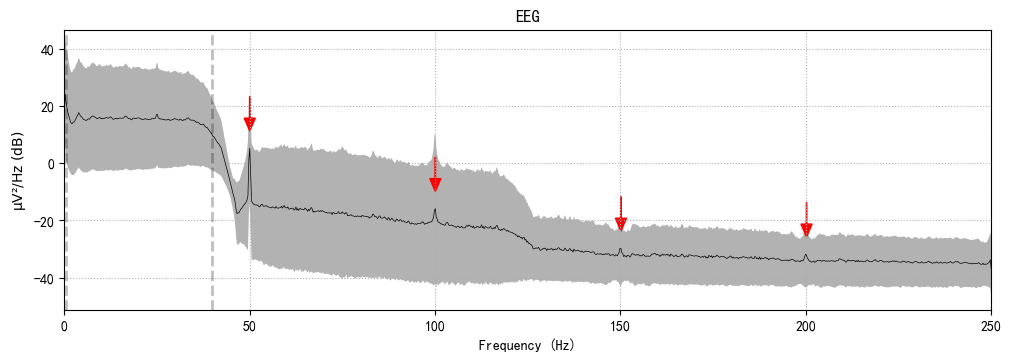

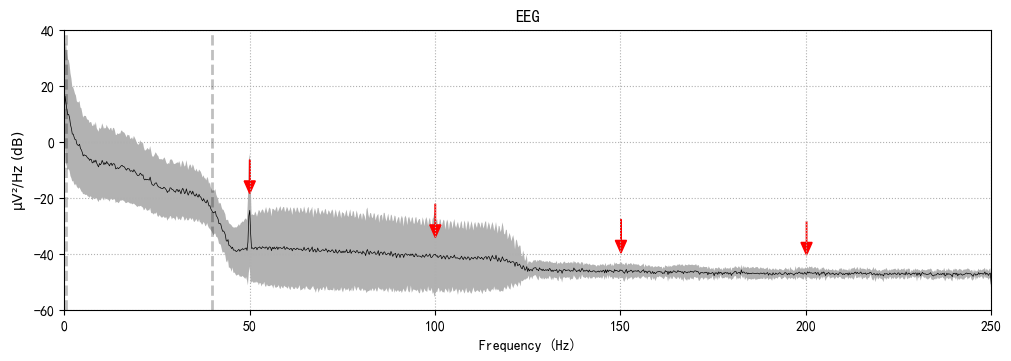

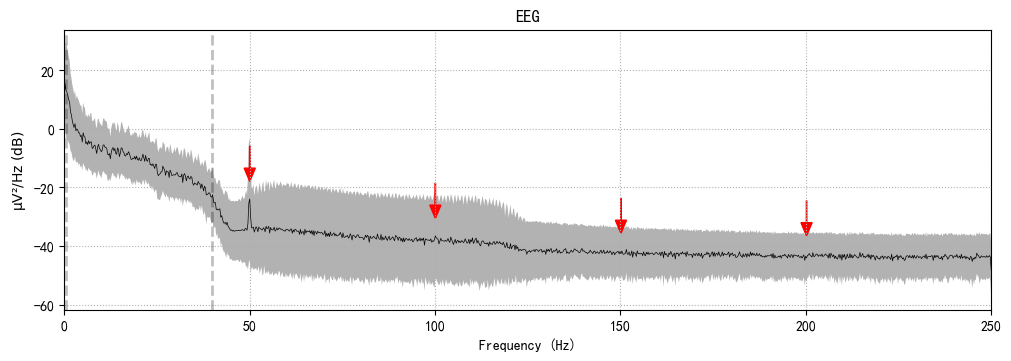

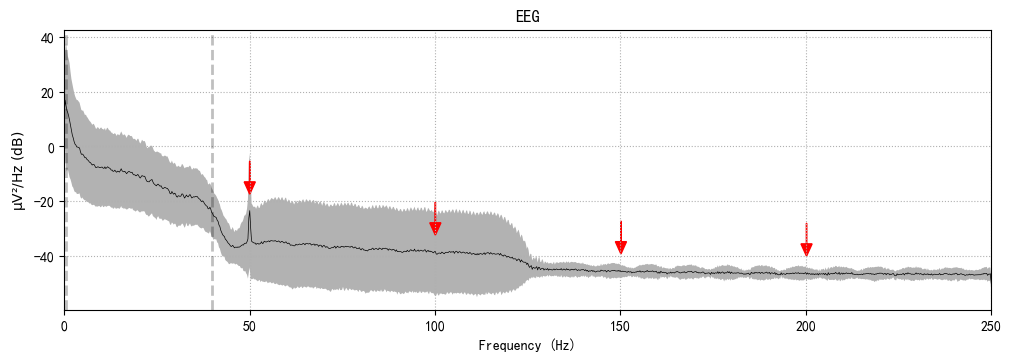

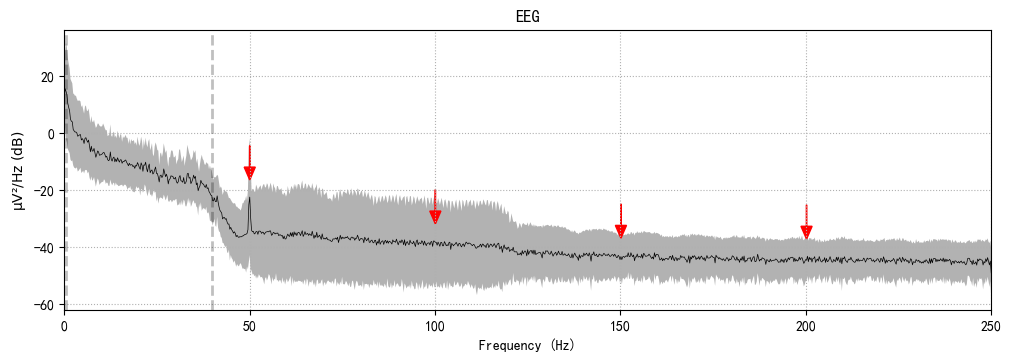

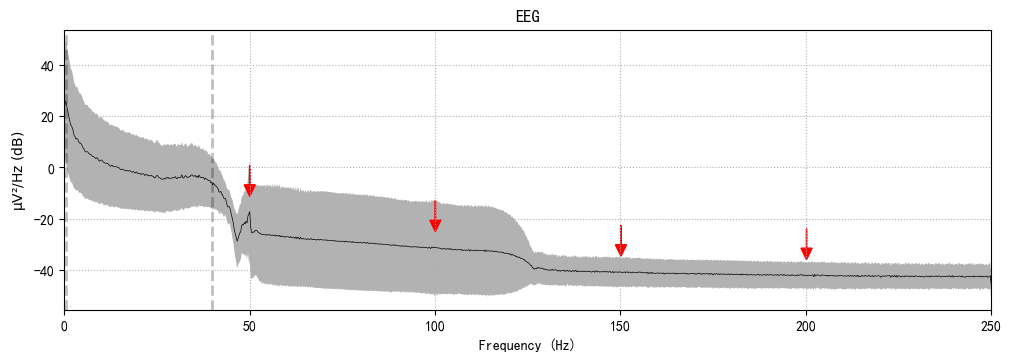

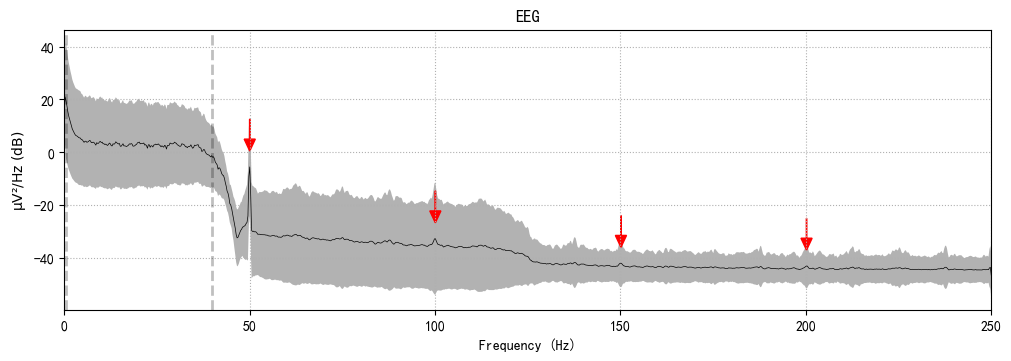

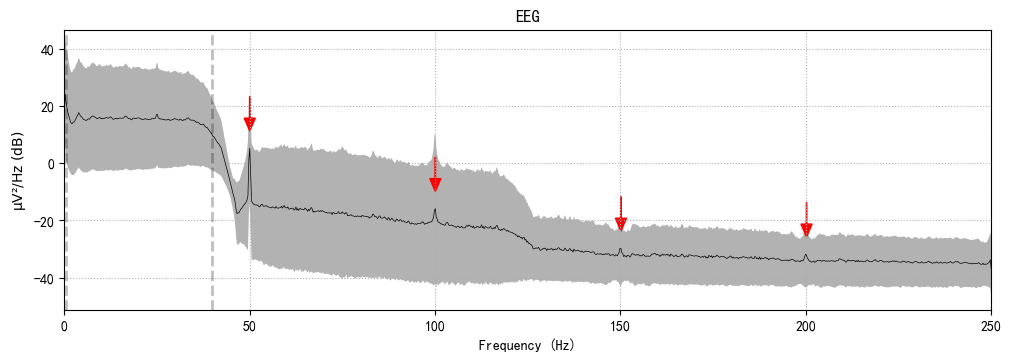

In [40]:
%matplotlib inline
def add_arrows(axes):
    """Add some arrows at 50 Hz and its harmonics."""
    for ax in axes:
        freqs = ax.lines[-1].get_xdata()
        psds = ax.lines[-1].get_ydata()
        for freq in (50, 100, 150, 200):
            idx = np.searchsorted(freqs, freq)
            # get ymax of a small region around the freq. of interest
            y = psds[(idx - 4) : (idx + 5)].max()
            ax.arrow(
                x=freqs[idx],
                y=y + 18,
                dx=0,
                dy=-12,
                color="red",
                width=0.1,
                head_width=3,
                length_includes_head=True,
            )


fig = test.compute_psd(fmax=250).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
add_arrows(fig.axes[:2])

Loop through all datasets: <br>
all data have power line noise.

In [41]:
import matplotlib
matplotlib.use('TkAgg') #plot outside of this notebook
import matplotlib.pyplot as plt

for raw in raws_3:
    fig = raw.compute_psd(fmax=250).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
    add_arrows(fig.axes[:2])
    

D:\Python\Lib\site-packages\mne\viz\_mpl_figure.py:2365: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(FigureClass=FigureClass, **kwargs)


In [42]:
#24


fig.axes[:2]

[<Axes: title={'center': 'EEG'}, xlabel='Frequency (Hz)', ylabel='$\\mathrm{µV²/Hz}$$\\ \\mathrm{(dB)}$'>]

In [43]:
i = 0
for raw in raws_3:
    i+=1
    print(raw)
    print(i)

<RawEDF | 200.edf, 12 x 7322500 (14645.0 s), ~14 kB, data not loaded>
1
<RawEDF | 201.edf, 15 x 22500 (45.0 s), ~17 kB, data not loaded>
2
<RawEDF | 202.edf, 15 x 6500 (13.0 s), ~17 kB, data not loaded>
3
<RawEDF | 203.edf, 15 x 64500 (129.0 s), ~17 kB, data not loaded>
4
<RawEDF | 204.edf, 15 x 8000 (16.0 s), ~17 kB, data not loaded>
5
<RawEDF | 205.edf, 15 x 65500 (131.0 s), ~17 kB, data not loaded>
6
<RawEDF | 206.edf, 15 x 2836500 (5673.0 s), ~17 kB, data not loaded>
7
<RawEDF | 207.edf, 15 x 18803500 (37607.0 s), ~17 kB, data not loaded>
8
<RawEDF | 208.edf, 15 x 24201000 (48402.0 s), ~17 kB, data not loaded>
9
<RawEDF | 209.edf, 15 x 9331500 (18663.0 s), ~17 kB, data not loaded>
10
<RawEDF | 210.edf, 15 x 7309500 (14619.0 s), ~17 kB, data not loaded>
11
<RawEDF | 211.edf, 15 x 24315000 (48630.0 s), ~17 kB, data not loaded>
12
<RawEDF | 212.edf, 15 x 22587500 (45175.0 s), ~17 kB, data not loaded>
13
<RawEDF | 213.edf, 12 x 8326000 (16652.0 s), ~14 kB, data not loaded>
14
<RawEDF |

In [44]:
# 